### Meta-connectivity

Analysis of the global meta-connectivity

In [1]:
# Adding GDa to path
import os
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import brainconn as bc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from config import sessions
from GDa.graphics import plot
from GDa.net.static import _modularity
from GDa.util import _extract_roi
from tqdm import tqdm

#### Plotting and file saving configurations

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda")
_RESULTS = "Results/lucy/meta_conn"


def get_file_name(session):
    return os.path.join(_ROOT, _RESULTS, f"MC_coh_{session}_global.nc")

In [4]:
MC = xr.load_dataarray(get_file_name("141017"))

#### Detecting communities in the MC matrix

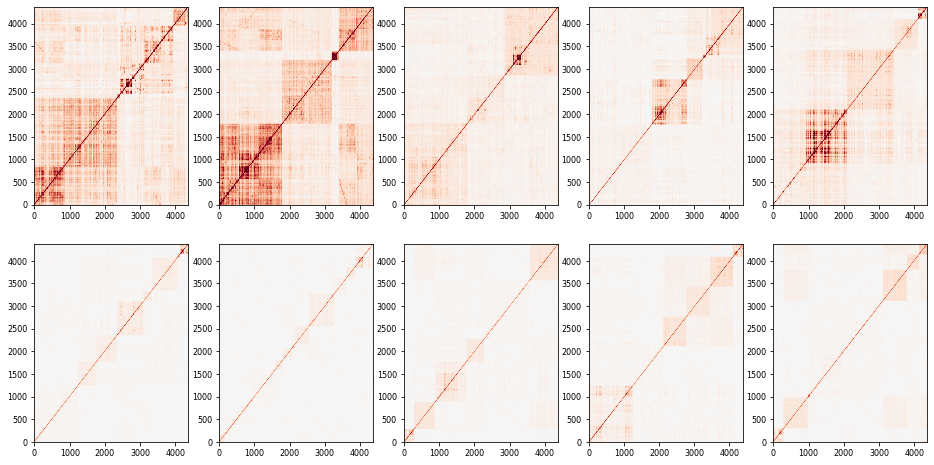

In [5]:
plt.figure(figsize=(16, 8))
for i in range(10):
    av, q = _modularity(A=MC.isel(freqs=i).values, backend="brainconn")
    idx = np.argsort(av)
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        MC.isel(freqs=i).values[np.ix_(idx, idx)],
        aspect="auto",
        cmap="RdBu_r",
        vmin=-0.1,
        vmax=0.1,
        origin="lower",
    )

In [6]:
def _trimmer_strengths(meta_conn, sources, targets, n_nodes=None):
    """Given a MC matrix it computes the trimmer strengths for each node"""
    # Get the number of nodes
    if n_nodes is None:
        n_nodes = np.max([sources, targets]) + 1
    # Store trimmer-strengths for each node
    ts = np.zeros(n_nodes)
    for i in range(n_nodes):
        # Get indexes where node i is present
        idx = np.logical_or(sources == i, targets == i)
        # Get sub-matrix only with meta-edges containing i
        sub_mat = meta_conn[np.ix_(idx, idx)]
        ts[i] = np.triu(sub_mat, 1).sum(axis=(0, 1))
    return ts